In [1]:
import timeit
import datetime as dt
import os
import subprocess 

import pandas as pd
import numpy as np

#for portofolio optimization 
import scipy.optimize as sco


#visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
%matplotlib inline
#visualization with seaborn
import seaborn as sns
#visualization with plotly 
import plotly.graph_objects as go #for candle chart visualization
import plotly.express as px #for html output


#to get financial data
from pandas_datareader import data as pdr


#for webscraping 
import requests
from bs4 import BeautifulSoup 
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import requests


#for pdf report generation
from reportlab.pdfgen import canvas
from reportlab.platypus import *
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.platypus.tableofcontents import TableOfContents


/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
days_to_lookback =  20    #int (input('days to search financial data:'))

In [3]:
riskfree = .0019

In [4]:
date_end = dt.datetime.now() #.today()
date_start = date_end - dt.timedelta(days_to_lookback)

# Create timestamped folder to save reports created later

In [5]:
#timestamp = str(dt.datetime.now()) <- '2020-06-26 20:26:08.775766'  
timestamp =  dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
timestamp

'2020-08-09 17-24-02'

In [6]:
path = os.getcwd() 
reportDir = os.path.join(path, "Markowitz portflio output " + timestamp)
reportDir

'/Users/reejungkim/Documents/Git/reporting automation/Markowitz portflio output 2020-08-09 17-24-02'

In [7]:
#create named folder
os.makedirs(reportDir, exist_ok = False)

In [8]:
os.chdir(reportDir)

# Web scraping S&P100 companies from Wikipedia table

In [9]:
website_url = requests.get("https://en.wikipedia.org/wiki/S%26P_100").text

soup = BeautifulSoup(website_url,'lxml')
#print(soup.prettify())

In [10]:
wiki_table = soup.find('table',{'class':'wikitable sortable'})

In [11]:
data = []
tHeader = []
SP100_tickers = pd.DataFrame()

for tr in wiki_table.find_all("tr"):
    for th in tr.find_all("th")[:1]:
        tHeader = th.get_text(strip=True)
        SP100_tickers[tHeader] = []
    for td in tr.find_all("td")[:1]:
        data.append( td.get_text(strip=True))
        
SP100_tickers[tHeader] = data

In [12]:
SP100_tickers

,Symbol
0,AAPL
1,ABBV
2,ABT
3,ACN
4,ADBE
...,...
96,VZ
97,WBA
98,WFC
99,WMT


# Use DataReader to get financial data of S&P100 companies from yahoo

In [13]:
%%time

df = pd.DataFrame()

for i in data:
    symbol = SP100_tickers.loc[SP100_tickers['Symbol']==i]
    try:
        symbol_data = pdr.DataReader(i, 'yahoo', date_start, date_end).reset_index()
        #display(symbol_data)  
    except (KeyError, ValueError):  # the error could possibly occur when there's "." in stock name 
        symbol_data = pdr.DataReader(i.replace('.','-'), 'yahoo', date_start, date_end).reset_index()
        #symbol_data = pd.DataFrame()
        pass
    except:
        print(i + " - Error.")
        symbol_data = pd.DataFrame()
        pass
    single_table = pd.concat([symbol, symbol_data], axis=0, ignore_index=True) #axis=0 <- row. add frames by row and use fill down.
    single_table['Symbol'].ffill(inplace=True)
    df = df.append(single_table)
    

CPU times: user 7.03 s, sys: 687 ms, total: 7.72 s
Wall time: 1min 9s


In [14]:
df = df.loc[df['Date'].notnull()]

In [15]:
df = df.reset_index(drop=True)

df.groupby(['Symbol']).describe().transpose()

In [16]:
df_Flat = df

# Prepare data frame to display volatility and to be normalized

In [17]:
d = df.pivot_table(values='Close', index='Date', columns='Symbol', aggfunc=np.sum, margins=False)

In [18]:
d.head()

Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-20,393.429993,99.540001,99.080002,223.429993,455.269989,31.410000,90.930000,260.950012,260.529999,3196.840088,...,303.459991,177.389999,118.349998,35.570000,198.470001,55.869999,40.459999,24.570000,131.470001,42.500000
2020-07-21,388.000000,97.400002,98.190002,222.750000,444.279999,31.959999,91.860001,257.910004,259.209991,3138.290039,...,305.109985,178.660004,119.040001,36.599998,196.479996,55.840000,40.410000,26.200001,132.330002,44.650002
2020-07-22,389.089996,97.699997,100.190002,224.229996,445.049988,32.189999,93.519997,256.980011,259.040009,3099.909912,...,306.709991,179.380005,118.720001,36.259998,198.860001,55.750000,40.689999,26.260000,132.660004,43.610001
2020-07-23,371.380005,98.029999,100.820000,222.300003,431.739990,31.870001,94.669998,252.240005,257.899994,2986.550049,...,302.970001,175.000000,118.139999,36.770000,197.429993,55.849998,40.340000,26.350000,131.639999,43.700001
2020-07-24,370.459991,97.110001,98.949997,221.440002,430.309998,31.309999,94.360001,247.979996,256.329987,3008.909912,...,300.790009,176.119995,118.349998,36.919998,195.149994,56.849998,40.509998,26.260000,131.240005,43.430000


In [19]:
logChange = np.log(d / d.shift(1)) # geometric brownian motion. - make the errors being normally distributed.
# more standardly used than pct_change.  df_temp['Close'] in this case.
logChange.head()

Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-21,-0.013898,-0.021733,-0.009023,-0.003048,-0.024436,0.017359,0.010176,-0.011718,-0.005080,-0.018485,...,0.005423,0.007134,0.005813,0.028546,-0.010077,-0.000537,-0.001237,0.064233,0.006520,0.049350
2020-07-22,0.002805,0.003075,0.020164,0.006622,0.001732,0.007171,0.017910,-0.003612,-0.000656,-0.012305,...,0.005230,0.004022,-0.002692,-0.009333,0.012040,-0.001613,0.006905,0.002287,0.002491,-0.023568
2020-07-23,-0.046585,0.003372,0.006268,-0.008644,-0.030363,-0.009991,0.012222,-0.018617,-0.004411,-0.037254,...,-0.012269,-0.024721,-0.004897,0.013967,-0.007217,0.001792,-0.008639,0.003421,-0.007719,0.002062
2020-07-24,-0.002480,-0.009429,-0.018722,-0.003876,-0.003318,-0.017728,-0.003280,-0.017033,-0.006106,0.007459,...,-0.007221,0.006380,0.001776,0.004071,-0.011616,0.017747,0.004205,-0.003421,-0.003043,-0.006198


# pick tickers to use for portfolio
( highest growth rates)

In [20]:
tickers = pd.DataFrame((d.mean()/d.var()))
tickers.columns =['sharp']
tickers = tickers.sort_values(by='sharp', ascending=False).head(10)
symbols = tickers.index.tolist()
symbols

['ORCL', 'T', 'F', 'WBA', 'CSCO', 'KHC', 'MO', 'EXC', 'KMI', 'CMCSA']

tickers_bestPerformed = logChange.describe().transpose().sort_values(by='mean', ascending=False).head(5)
symbols = tickers_bestPerformed.index.tolist()

In [21]:
logChange = logChange[symbols]
logChange.head(3)

Symbol,ORCL,T,F,WBA,CSCO,KHC,MO,EXC,KMI,CMCSA
Date,,,,,,,,,,
2020-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-21,0.009164,0.013311,0.002999,-0.001237,0.001064,0.011945,0.008527,0.010643,0.039884,0.014671
2020-07-22,0.001787,-0.002980,0.023670,0.006905,-0.002555,0.010658,0.002907,0.006691,-0.013342,0.000000


### expected return of each ticker picked

In [22]:
logChange.mean()*252   #252 business days per year in general

Symbol
ORCL    -0.055320
T        0.102222
F        0.532584
WBA      0.465506
CSCO     0.175425
KHC      0.667990
MO       0.563630
EXC      0.284278
KMI     -0.224847
CMCSA    0.365279
dtype: float64

##### covariance across tickers

In [23]:
logChange.cov()*252

Symbol,ORCL,T,F,WBA,CSCO,KHC,MO,EXC,KMI,CMCSA
Symbol,,,,,,,,,,
ORCL,0.008682,0.005163,0.001118,0.007884,0.002129,0.011451,-0.003651,0.007986,0.015390,0.006004
T,0.005163,0.017711,0.005382,0.008499,-0.003193,0.008358,0.007466,0.021451,0.024735,-0.000924
F,0.001118,0.005382,0.070873,-0.000989,0.006268,0.025867,0.017698,-0.004287,0.009293,-0.003864
WBA,0.007884,0.008499,-0.000989,0.028126,-0.015512,0.016797,-0.002071,0.015477,0.006406,0.001381
CSCO,0.002129,-0.003193,0.006268,-0.015512,0.036234,0.008826,-0.009506,0.009782,0.011811,0.001090
KHC,0.011451,0.008358,0.025867,0.016797,0.008826,0.040019,0.001611,0.018652,0.024682,0.014226
MO,-0.003651,0.007466,0.017698,-0.002071,-0.009506,0.001611,0.023591,0.005028,0.001727,0.001011
EXC,0.007986,0.021451,-0.004287,0.015477,0.009782,0.018652,0.005028,0.062486,0.042245,0.009895
KMI,0.015390,0.024735,0.009293,0.006406,0.011811,0.024682,0.001727,0.042245,0.103085,0.026902


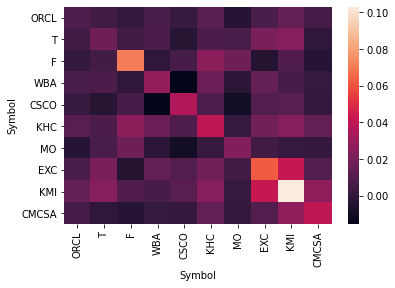

In [24]:
sns.heatmap(logChange.cov()*252)

# Portfolio with randomly assinged weights

#### get random portofolio weights to run simulations

In [25]:
np.random.seed(0)
weights = np.random.random(len(symbols))
weights /= np.sum(weights)
weights

array([0.08912692, 0.11614624, 0.09788834, 0.08848864, 0.06880123,
       0.10489274, 0.07106385, 0.14482329, 0.15649814, 0.06227063])

In [26]:
#expeced annual return of portfolio
np.sum(logChange.mean()*weights)*252

0.251186452537646

In [27]:
#expected annual variance of portfolio
np.dot(weights.T, np.dot(logChange.cov() * 252, weights))

0.015752249976907915

In [28]:
#expected annual standard deviation of portfolio (volatility)
np.sqrt(np.dot(weights.T, np.dot(logChange.cov() * 252, weights)))

0.12550796778255918

# Simulation of portfolios with random weights

In [29]:
prets = []  #stores list of portfolio returns
pvols = []  #stores list of portolfio volatilities

for p in range (5000):
    weights = np.random.random(len(symbols))
    weights /= np.sum(weights)
    prets.append(np.sum(logChange.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(logChange.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

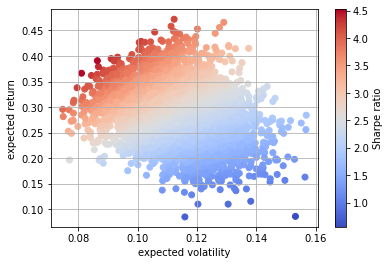

In [30]:

plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='coolwarm') # mpl.cm.jet)

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio') #beta
plt.show()

In [31]:
def statistics(weights):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
    
    Returns
    =======
    pret : float  (portfolio return)
    pvol : float   (portfoliio volatility)
    pret / pvol : float      #sharp ratio (beta)

    '''
    riskfree = .0019   #risk free rate .19% (1 Year Treasury Rate is at 0.19%)
    weights = np.array(weights)
    pret = np.sum(logChange.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(logChange.cov() * 252, weights)))
    return np.array([pret, pvol, ((pret-riskfree )/ pvol)])

### Sharp ratio optimization

In [32]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [33]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
cons

{'type': 'eq', 'fun': <function __main__.<lambda>(x)>}

In [34]:
#return, volatility, and sharp ratio when portfolio is weighted equally
w = len(symbols)*[1. /len(symbols),]
statistics(w)

array([0.28767464, 0.10781599, 2.65057742])

In [35]:
bnds = tuple((0, 1) for x in range(len(symbols)))
bnds

((0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1))

In [36]:
#set initial point
len(symbols)* [1./len(symbols),]

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

#### Minimize a scalar function of one or more variables using Sequential Least Squares Programming (SLSQP).

#### scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)

In [37]:
%%time

opts = sco.minimize(min_func_sharpe, len(symbols)* [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)


CPU times: user 149 ms, sys: 2.79 ms, total: 152 ms
Wall time: 150 ms


In [38]:
opts

     fun: -6.7590089360271834
     jac: array([ 4.81096631,  6.34581685,  4.62907171, -0.0311029 , -0.03109038,
        5.6052739 , -0.03097939, 13.31313574, 16.93226445, -0.03079879])
 message: 'Optimization terminated successfully.'
    nfev: 161
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.22410455e-01,
       2.71888684e-01, 1.18666395e-11, 3.51173048e-01, 2.35577801e-12,
       2.38740891e-12, 5.45278123e-02])

In [39]:
a=opts['x'].round(3)   #opt weights
#print("exp return :" + str( np.sum(logChange.mean()*a)*252  )  ).round(3)   #1yr exp return of portfolio with opt weights 
print("exp return :" + str( statistics(opts['x'].round(3))[0].round(3) ) )
print("exp volatility :" + str( statistics(opts['x'].round(3))[1].round(3) )  )
print("exp sharp ratio :" + str( statistics(opts['x'].round(3))[2].round(3) )  )

exp return :0.416
exp volatility :0.061
exp sharp ratio :6.759


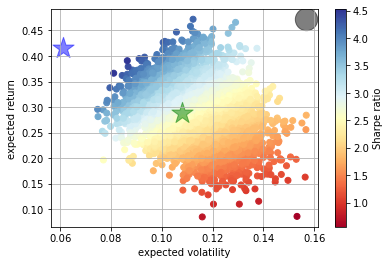

In [40]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='RdYlBu')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')


#return, volatility, and sharp ratio when portfolio is weighted equally
w = len(symbols)*[1. /len(symbols),]
plt.scatter(statistics(w)[1], statistics(w)[0], marker="*", s= 500, alpha=0.5, color='g')


# add a red dot for maximum vol & maximum return
plt.scatter(pvols.max(), prets.max(), c='black', s=500, alpha=0.5, edgecolors='black')



plt.show()

### Volatility Optimization

In [41]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [42]:
optv = sco.minimize(min_func_variance,  len(symbols) * [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [43]:
optv

     fun: 0.0033148148195430416
     jac: array([0.00641366, 0.00859447, 0.01322269, 0.00679661, 0.00671447,
       0.01838296, 0.00658333, 0.01854906, 0.01779616, 0.00666749])
 message: 'Optimization terminated successfully.'
    nfev: 168
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([0.21055891, 0.        , 0.        , 0.219378  , 0.24956333,
       0.        , 0.29066586, 0.        , 0.        , 0.0298339 ])

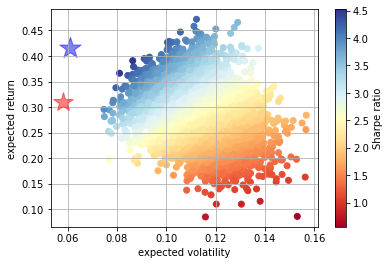

In [44]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='RdYlBu')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')


# Optimal (minimum) volatility
pt_optv = statistics(optv['x']).round(3)
plt.plot(pt_optv[1], pt_optv[0], marker="*", markersize=20, alpha=0.5, color='r')
#plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=20, color='r')
           
    
plt.show()

# Efficient Frontier

## Minimum variance frontier

In [45]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [46]:
def min_func_port(weights):
    return statistics(weights)[1]

In [47]:
prets.min(), prets.max(), pt_opts[0]

(0.08476465172226266, 0.4719539385489902, 0.416)

In [48]:
%%time


trets = np.linspace( prets.min() , max(prets.max(), pt_opts[0].max()), 50)
tvols = []
for tret in trets:       #getting weight where minimum volatility occurs for each returned value
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, len(symbols)* [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 9.38 s, sys: 34.4 ms, total: 9.41 s
Wall time: 9.44 s


In [49]:
tvols

array([0.06744196, 0.06653994, 0.06571338, 0.064964  , 0.06429568,
       0.06370529, 0.06314875, 0.06261606, 0.06210757, 0.06162412,
       0.06116682, 0.06073485, 0.06032983, 0.05995238, 0.05960299,
       0.05928184, 0.05898909, 0.05872536, 0.05848793, 0.05827616,
       0.05809024, 0.05792965, 0.0577958 , 0.05768837, 0.05760752,
       0.05755335, 0.05752595, 0.05752534, 0.05755152, 0.05760443,
       0.05768399, 0.05779044, 0.05792277, 0.0580816 , 0.05826648,
       0.05847734, 0.05871366, 0.05897516, 0.05926148, 0.05957224,
       0.05990652, 0.06038655, 0.06136536, 0.06284309, 0.06478598,
       0.06707979, 0.06945021, 0.07187075, 0.07433625, 0.07684239])

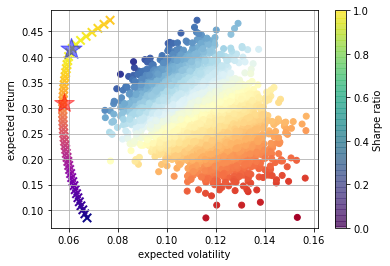

In [50]:
# rangdomly weighted sample portfolio simulations
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='RdYlBu')


# Minimum variance frontier
plt.scatter(tvols, trets, c=trets / tvols, marker='x', s=70, linewidth=2, cmap='plasma')
            
    
#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')


# Optimal (minimum) volatility
pt_optv = statistics(optv['x']).round(3)
plt.plot(pt_optv[1], pt_optv[0], marker="*", markersize=20, alpha=0.5, color='r')
#plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=20, color='r')

 
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

## Efficient frontier

In [51]:
import scipy.interpolate as sci

In [52]:
np.argmin(tvols) #find index of minimum value of volatility 


27

In [53]:
ind = np.argmin(tvols)
evols = tvols[ind:]    #include array only up to the index of minimum volatility
erets = trets[ind:]


In [54]:
tck = sci.splrep(evols, erets)

In [55]:
def f(x):
    ''' efficient frontier (spline) '''
    return sci.splev(x, tck, der=0)

def df(x):
    ''' efficient frontier (first derivative)'''
    return sci.splev(x, tck, der=1)
f(0)

array(-2716354.92965154)

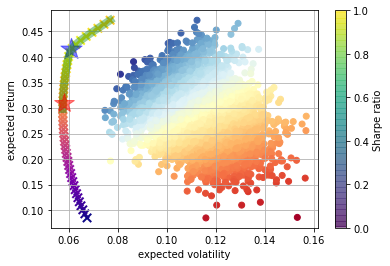

In [56]:
# rangdomly weighted sample portfolio simulations
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='RdYlBu')


# Efficient frontier
plt.plot(evols, f(evols), lw=8, alpha=0.4, color='green')  

# Minimum variance frontier
plt.scatter(tvols, trets, c=trets / tvols, marker='x', s=70, linewidth=2, cmap='plasma')
            
#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')

# Optimal (minimum) volatility
pt_optv = statistics(optv['x']).round(3)
plt.plot(pt_optv[1], pt_optv[0], marker="*", markersize=20, alpha=0.5, color='r')
#plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=20, color='r')
 

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

## Capital market line (CML)

In [57]:
riskfree

0.0019

In [58]:
def equations(p, rf=riskfree):
    eq1 = rf-p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [59]:
pvols.max()/2, prets.max()/2


(0.07841159208385894, 0.2359769692744951)

In [60]:
opt = sco.fsolve(equations,[ riskfree, pvols.max()/2, prets.max()/2])
opt

array([1.90000000e-03, 4.54441926e+00, 1.73349571e-01])

In [61]:
np.round(equations(opt), 8)

array([ 0., -0.,  0.])

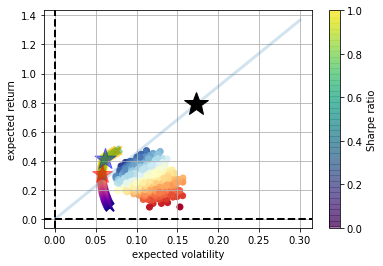

In [62]:
# rangdomly weighted sample portfolio simulations
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='RdYlBu')


# Efficient frontier
plt.plot(evols, f(evols), lw=8, alpha=0.4, color='green')  

# Minimum variance frontier
plt.scatter(tvols, trets, c=trets / tvols, marker='x', s=70, linewidth=2, cmap='plasma')
            
#highest sharp ratio
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0], marker="*", s=500, alpha=0.5, color='b')

# Optimal (minimum) volatility
pt_optv = statistics(optv['x']).round(3)
plt.plot(pt_optv[1], pt_optv[0], marker="*", markersize=20, alpha=0.5, color='r')
#plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=20, color='r')
 


 
#Capital market line
cx = np.linspace(riskfree, 0.3 )   # (0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=3, alpha=0.2, ) 
    
    
#optimal portfolio  
plt.plot(opt[2], f(opt[2]), 'r*', markersize=25.0, color='black') 


plt.grid(True)
plt.axhline(0.0, color='k', ls='--', lw=2.0)
plt.axvline(0.0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

#### Optimal portfolio weights

In [63]:
symbols

['ORCL', 'T', 'F', 'WBA', 'CSCO', 'KHC', 'MO', 'EXC', 'KMI', 'CMCSA']

In [64]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
res = sco.minimize(min_func_port, len(symbols) * [1. / len(symbols),], method='SLSQP',
                       bounds=bnds, constraints=cons)
res['x'].round(3)

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [65]:
statistics(res['x'].round(3))

array([0.66799027, 0.20004853, 3.32964338])

#### return, volatility, and sharp ratio expected with the optimal weights

In [66]:
portfolio = list(zip(symbols, res['x'].round(3)))
portfolio

[('ORCL', 0.0),
 ('T', 0.0),
 ('F', 0.0),
 ('WBA', 0.0),
 ('CSCO', 0.0),
 ('KHC', 1.0),
 ('MO', 0.0),
 ('EXC', 0.0),
 ('KMI', 0.0),
 ('CMCSA', 0.0)]

In [67]:
def format_column_number(dataframe, listCols):
    for col in listCols:
        try:
            dataframe[col]= pd.Series([round(val, 2 ) for val in dataframe[col]], index= dataframe.index)
        except ValueError:  #skips error when the column is in format already
            dataframe[col] = dataframe[col]
            pass
    return dataframe

def format_column_percentage(dataframe, listCols):
    for col in listCols:
        try:
            dataframe[col] = pd.Series(["{0:.2f}%".format(val*100) for val in dataframe[col]], index= dataframe.index)
        except ValueError:  #skips error when the column is in format already
            dataframe[col] = dataframe[col]
        
    return dataframe

In [68]:
summary_output = pd.DataFrame({'Symbol': symbols})
summary_output['Weight'] = res['x'].round(3)

summary_output = pd.merge(summary_output , (logChange.mean()*252).reset_index(name='temp'))

summary_output['Exp return'] = summary_output['Weight']*summary_output['temp']

summary_output = summary_output.pivot_table(index='Symbol', values=['Weight', 'Exp return']  , aggfunc=np.sum, margins=True)


format_column_percentage(summary_output, ['Exp return', 'Weight'])
summary_output

,Exp return,Weight
Symbol,,
CMCSA,0.00%,0.00%
CSCO,0.00%,0.00%
EXC,0.00%,0.00%
F,0.00%,0.00%
KHC,66.80%,100.00%
KMI,0.00%,0.00%
MO,0.00%,0.00%
ORCL,0.00%,0.00%
T,0.00%,0.00%


In [69]:
today = dt.datetime.today().strftime('%Y-%m-%d')
pdf_file_name = "Report "+ today +".pdf"

In [70]:
def PrepareTableForReportLab(dataframe):
    
    data = dataframe

    'handling grouped first index column'
    a= []
    for i in range(len(data)):
        #print(i, data.index.get_level_values(0)[i])
        if data.index.get_level_values(0)[i-1] == data.index.get_level_values(0)[i]:
            a.append(i)
    a.sort(reverse=True)

    as_list = data.index.get_level_values(0).tolist()
    for i in a:
        as_list[i] = ""

        
    'flat dataframe'
    data = data.reset_index()
    'remove duplicated values from first column which was index before resetting index'
    first_col_name = data.columns[0]
    data[first_col_name] = as_list 
    
    #data = dataframe.reset_index()
    #colwidths = 800/len(data.columns) 
    data = [data.columns.to_list()] + data.values.tolist() 

    #tbl = Table(data) # 
    tbl = Table(data) #, colwidths ) #, rowheights)
    tbl.setStyle(TableStyle([
    ('INNERGRID', (0, 0), (-1, -1), 0.25, colors.black),
    ('BOX', (0, 0), (-1, -1), 0.25, colors.black),
    ('ALIGN', (1,1), (-1,-1), 'RIGHT'),
    ('BACKGROUND', (0,0), (-1,0), colors.Color(0,0.7,0.7))
    ]))
    
    return tbl

In [71]:
story = []

In [72]:
story.append(Paragraph("Portfolio", getSampleStyleSheet()['Heading1']))
story.append(PrepareTableForReportLab(summary_output))

story.append(PageBreak())

In [73]:
doc = SimpleDocTemplate(pdf_file_name, pagesize = landscape(letter), topMargin = inch * .25, bottomMargin = inch * .25)
doc.build(story)

In [74]:
#Open pdf file generated
subprocess.run(['open', pdf_file_name], check=True)

CompletedProcess(args=['open', 'Report 2020-08-09.pdf'], returncode=0)